In [2]:
deps <- c("ISLR", "Metrics", "tidyr", "microbenchmark", "dplyr", "gridExtra", "readxl", "cvTools", "leaps", "assertthat", "assertr", "testthat")
for (p in deps) {
    if (!requireNamespace(p, quietly = TRUE)) {
        install.packages(p, repos = "https://cran.rstudio.com")
    }
    library(p, character.only = TRUE)
}

options(scipen=999)
set.seed(42)

In [6]:
df <- read.csv("../data/final_n1000.csv", header = TRUE, sep = ",")
df

X0
<chr>
"{'language': 'en', 'sentiment': 'neutral', 'sentiment_score': 0.38404980301856995, 'subjectivity_score': 0.7432339191436768, 'aspects': ['small', 'fit', 'found', 'stretch'], 'rating': 4.0}"
"{'language': 'en', 'sentiment': 'negative', 'sentiment_score': 0.4201246500015259, 'subjectivity_score': 0.9761059880256653, 'aspects': ['tone', 'horrified', 'orange pink', 'accurately test'], 'rating': 5.0}"
"{'language': 'en', 'sentiment': 'positive', 'sentiment_score': 0.9771382808685303, 'subjectivity_score': 0.9748688340187073, 'aspects': [], 'rating': 5.0}"
"{'language': 'en', 'sentiment': 'positive', 'sentiment_score': 0.7187591195106506, 'subjectivity_score': 0.7812371850013733, 'aspects': [], 'rating': 5.0}"
"{'language': 'en', 'sentiment': 'positive', 'sentiment_score': 0.706739604473114, 'subjectivity_score': 0.9757173657417297, 'aspects': ['perfectly', 'tone'], 'rating': 5.0}"
"{'language': 'en', 'sentiment': 'negative', 'sentiment_score': 0.5332693457603455, 'subjectivity_score': 0.9799292683601379, 'aspects': ['everywhere.', 'gorgeous', 'stick', 'open'], 'rating': 5.0}"
"{'language': 'en', 'sentiment': 'positive', 'sentiment_score': 0.6031196713447571, 'subjectivity_score': 0.6022505164146423, 'aspects': [], 'rating': 4.0}"
"{'language': 'en', 'sentiment': 'neutral', 'sentiment_score': 0.41761061549186707, 'subjectivity_score': 0.528902530670166, 'aspects': ['requires', 'youthful', 'wrinkles.', 'market', 'glow', 'actual change'], 'rating': 1.0}"
"{'language': 'en', 'sentiment': 'neutral', 'sentiment_score': 0.3659980595111847, 'subjectivity_score': 0.7364693284034729, 'aspects': ['roll', 'individually wrapped', 'leg', 'arm'], 'rating': 5.0}"


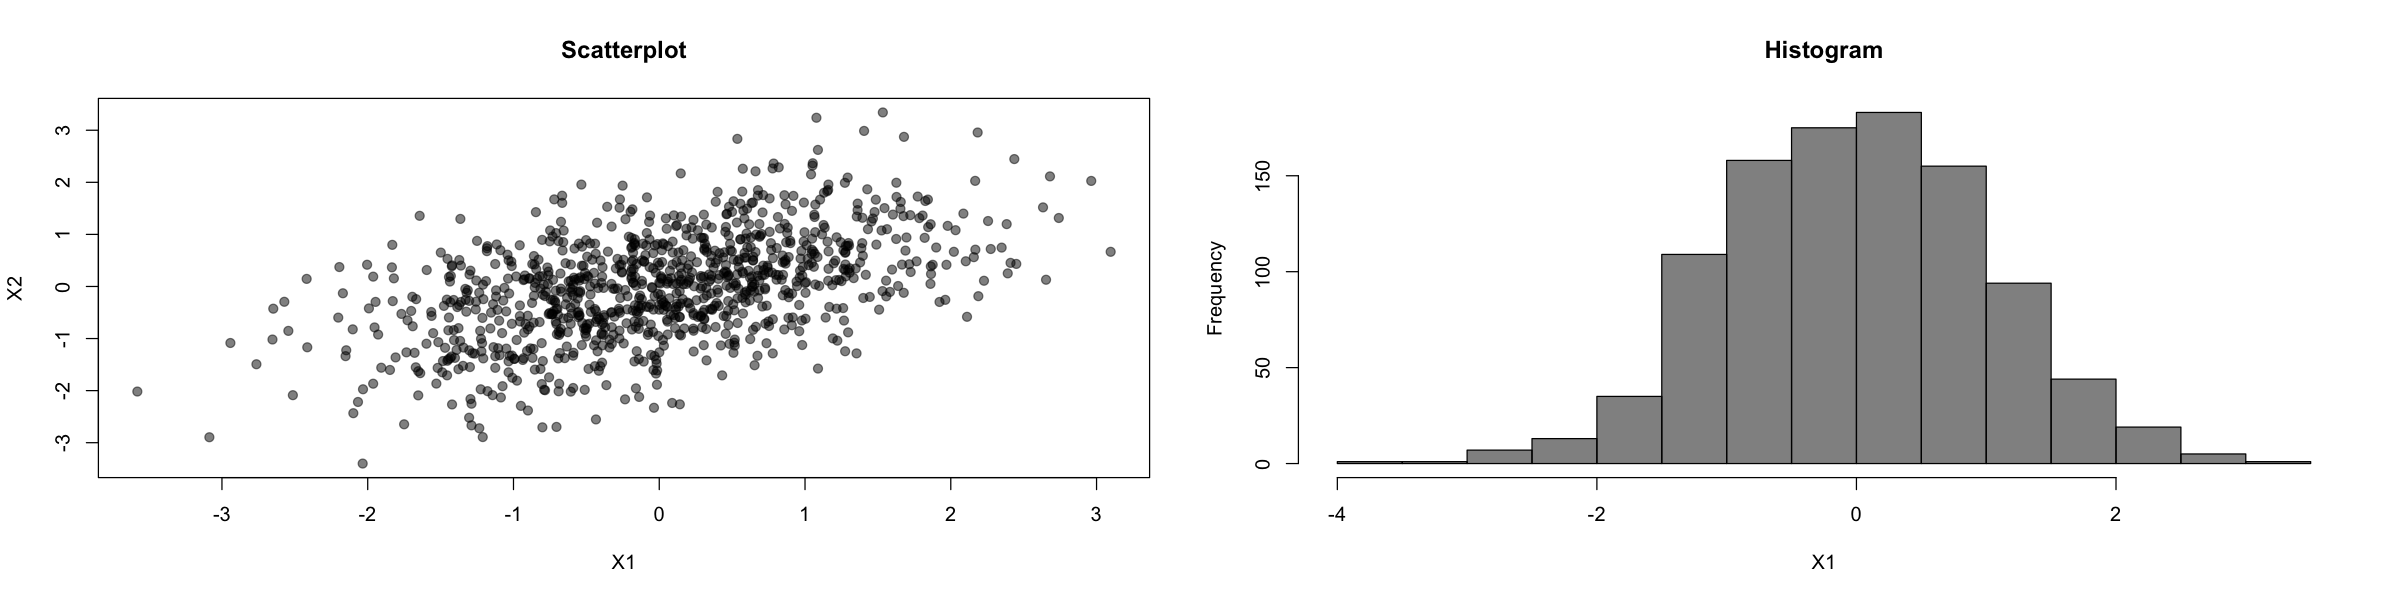

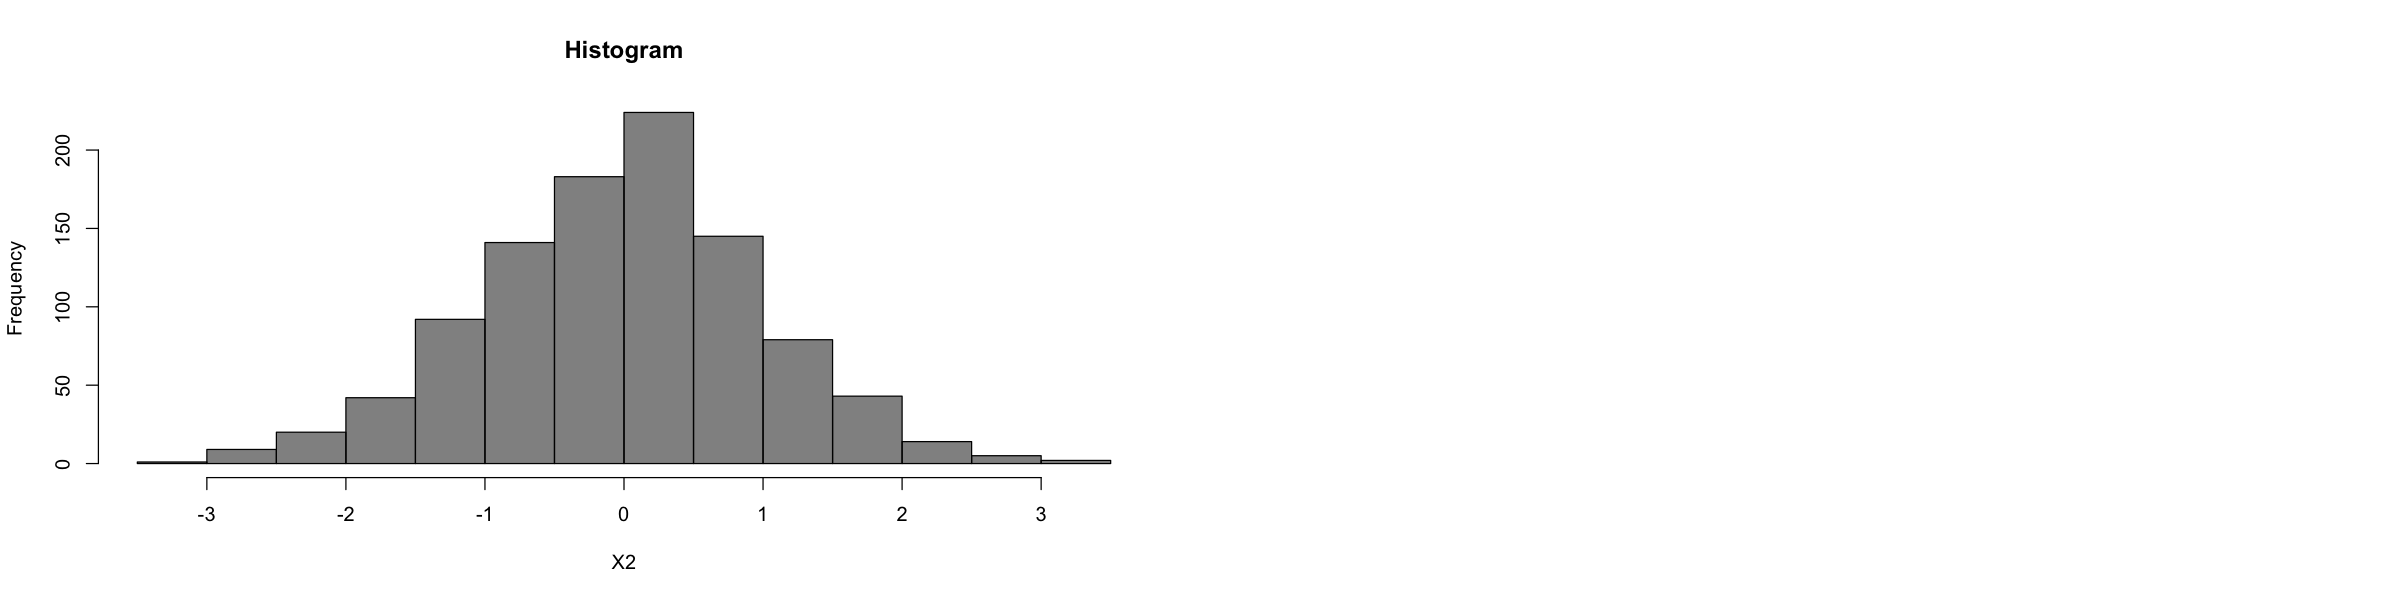

In [ ]:
options(repr.plot.width=20, repr.plot.height=5)

# multivariate normal distribution
n <- 1000
mu <- c(0, 0)
sigma <- matrix(c(1, 0.5, 0.5, 1), nrow=2)
data <- MASS::mvrnorm(n, mu, sigma)

# plot
par(mfrow=c(1, 2))
plot(data, col=rgb(0, 0, 0, 0.5), pch=19, xlab="X1", ylab="X2", main="Scatterplot")
hist(data[,1], col=rgb(0, 0, 0, 0.5), xlab="X1", main="Histogram")
hist(data[,2], col=rgb(0, 0, 0, 0.5), xlab="X2", main="Histogram")